In [408]:
import pywt
import numpy as np

### 问题定义

In [409]:
# - (alpha u')' + beta u = f

def alpha(x):
    return x * 0 + 1

def beta(x):
    return x * 0 - 1

def f(x):
    return (np.pi ** 2 / 9 - 4) * np.sin(np.pi / 6 * x) + (np.pi ** 2 / 4 - 1) * np.sin(np.pi / 2 * x)
    # return - 2 - x ** 2

# u(a) = c, u(b) = d
# a < x < b

a = 1
b = 2
c = 3
d = 2 * np.sqrt(3)

### 求解与重构

In [410]:
# v(0) = c, v(2N-1) = d, 其余不变
def simple_wavelet_solve(alpha, beta, f, c : float, d : float, N : int, p : int, m : int):
    
    phi = np.array(pywt.Wavelet('db' + str(N)).wavefun(m)[0])
    # phi[i] = phi(i / 2^m)
    # i 从 0 到 (2N - 1) * 2^m

    M = 2 ** p * (2 * N - 1) - 2 * N + 2
    # 下标 0 到 2^p(2N-1) - 2N + 1 
    # 下标 j 表示 supp 为 j / 2^p 到 (2N-1+j) / 2^p 的 基
    # phi_{p,j}(x) = 2^(p/2) phi(2^p x - j)

    phi = phi * 2 ** (p / 2)
    # phi[i] = phi_{p,0}( i / 2 ^ (m + p) )

    dphi = phi.copy() # copy 是复制 否则会复制指针
    dphi[1:-1] = (phi[2:] - phi[0:-2]) * 2 ** (m + p - 1)
    # f'(x) 用 (f(x + h) - f(x - h)) / 2h 估算
    # dphi[i] = phi_{p,0}'( i / 2 ^ (m + p) )

    # construct A
    A = np.zeros([M, M])
    for i in range(M):
        for j in range(max(i - 2 * N + 2,0), min(i + 2 * N - 1, M)):
            if j < i:
                A[i, j] = A[j, i]
            else:
                # j / 2^p 到 (2N-1+i) / 2^p 积分 复化梯形 两侧均为0无需乘1/2
                x = j / 2 ** p + np.array(range((2 * N - 1 + i - j) * 2 ** m + 1)) / 2 ** (m + p)
                A[i, j] = np.sum(alpha(x) * dphi[0:(2*N-1+i-j)*2**m+1] * dphi[(j-i)*2**m:] \
                    + beta(x) * phi[0:(2*N-1+i-j)*2**m+1] * phi[(j-i)*2**m:])
                A[i, j] = A[i, j] / 2 ** (m + p)
    
    F = np.zeros(M)
    k = (d - c) / (2 * N - 1)
    for i in range(M):
        x = i / 2 ** p + np.array(range((2 * N - 1) * 2 ** m + 1)) / 2 ** (m + p)
        # 计算 fv 积分
        F[i] = np.sum(f(x) * phi) / 2 ** (m + p)
        # 计算 A(u0, v)
        F[i] -= np.sum(alpha(x) * dphi * k + beta(x) * (k * x + c) * phi) / 2 ** (m + p)

    # ci 代表 dbN_p, i 的系数, i 从 0 到 2^p(2N-1) - 2N + 1
    C = np.linalg.solve(A, F)
    
    # 重构 v
    v = np.zeros((2 * N - 1) * 2 ** (p + m) + 1)
    for i in range(M):
        v[2 ** m * i:2 ** m * (2 * N - 1 + i) + 1] += C[i] * phi
    
    x = np.array(range((2 * N - 1) * 2 ** (p + m) + 1)) / 2 ** (m + p)
    return v + k * x + c

### 区间归一化

In [411]:
def wavelet_solve(alpha, beta, f, a : float, b : float, c : float, d : float, N : int, p : int, m : int):
    # v(x) = u( a + x * (b - a) / (2N - 1) )
    def alpha0(x):
        return alpha(a + x * (b - a) / (2 * N - 1)) * (2 * N - 1) ** 2 / (b - a) ** 2
    def beta0(x):
        return beta(a + x * (b - a) / (2 * N - 1))
    def f0(x):
        return f(a + x * (b - a) / (2 * N - 1))
    # 虽然数组每个位置对应的 x 不同，但数组区间无需处理
    v = simple_wavelet_solve(alpha0, beta0, f0, c, d, N, p, m)
    return v

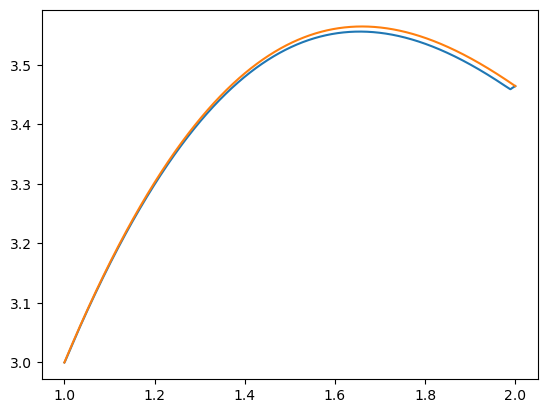

L2 Error: 0.0072468496500259615


In [412]:
N = 4
p = 6
m = 10
res = wavelet_solve(alpha, beta, f, a, b, c, d, N, p, m)
x = a + np.array(range(2 ** (m + p) * (2 * N - 1) + 1)) * (b - a) / (2 ** (m + p) * (2 * N - 1))

from matplotlib import pyplot as plt
plt.plot(x, res)
plt.plot(x, 4 * np.sin(np.pi * x / 6) + np.sin(np.pi * x / 2))
plt.show()

def l2err(res, real, a, b):
    l = b - a
    err = real - res
    err = err ** 2
    s = (np.sum(err) - (err[0] + err[-1]) / 2) / err.size * l
    return np.sqrt(s)

print("L2 Error: " + str(l2err(res, 4 * np.sin(np.pi * x / 6) + np.sin(np.pi * x / 2), a, b)))
